In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text
from tqdm.notebook import tqdm
from utils import *

In [3]:
import debugpy
debugpy.listen(5678)

('127.0.0.1', 5678)

In [4]:
PATH = Path('/home/slex/data/shopee')

In [5]:
train_df = pd.read_csv(PATH/'train_split.csv')
train_df['is_valid'] = train_df.split==0
train_df = add_target_groups(train_df)

In [6]:
class TitleTransform(Transform):
    def __init__(self, text_embeddings):
        super().__init__()
        self.text_embeddings = text_embeddings
        
        
    def encodes(self, row):
        idx = row.row_idx
        emb = self.text_embeddings[idx].toarray()
        emb = np.float32(emb)
        return emb.squeeze()
        
sk_model = sklearn.feature_extraction.text.TfidfVectorizer(stop_words='english', binary=True, max_features=25_000)
text_embeddings =sk_model.fit_transform(train_df.title)
title_transform = TitleTransform(text_embeddings)

In [142]:
len(sk_model.vocabulary_)

24939

In [7]:
data_block = DataBlock(
    blocks = (TransformBlock(type_tfms=title_transform), 
              CategoryBlock(vocab=train_df.label_group.to_list())),
    splitter=ColSplitter(),
    get_y=ColReader('label_group'),
    )
dls = data_block.dataloaders(train_df, bs=512,num_workers=16)

In [8]:
dls.valid.one_batch()[0].shape

torch.Size([512, 24939])

In [9]:
class ArcFaceClassifier(nn.Module):
    def __init__(self, emb_size, output_classes):
        super().__init__()
        self.W = nn.Parameter(torch.Tensor(emb_size, output_classes))
        nn.init.kaiming_uniform_(self.W)
    def forward(self, x):
        # Step 1:
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)
        # Step 2:
        return x_norm @ W_norm
    
def arcface_loss(cosine, targ, m=.7, s=30):
    cosine = cosine.clip(-1+1e-7, 1-1e-7) 
    arcosine = cosine.arccos()
    arcosine += F.one_hot(targ, num_classes = dls.c) * m
    cosine2 = arcosine.cos()
    cosine2 *= s
    return F.cross_entropy(cosine2, targ)

In [115]:
class SimpleModel(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        emb_dim=512
        factor = math.sqrt(in_features/emb_dim)
        mid_size = int(emb_dim*factor)
        lin1 = nn.Linear(in_features, mid_size)
        rel = nn.ReLU(inplace=True)
        bn1 = nn.BatchNorm1d(mid_size)
        drop1 = nn.Dropout()
        lin2 = nn.Linear(mid_size,emb_dim)
        bn2 = nn.BatchNorm1d(emb_dim)
        drop2 = nn.Dropout(.25)
        classifier = ArcFaceClassifier(emb_dim, out_features)
        self.layers = nn.Sequential(lin1, rel, bn1, drop1, lin2, rel, bn2,drop2, classifier)
    def forward(self, x):
        return self.layers(x)
        

In [117]:
def f1_score(pred_groups, real_groups):
    res =0
    for pred, real in zip(pred_groups, real_groups):
        inter = pred.intersection(real)
        res += 2 * len(inter) / (len(pred)+len(real))
    return res / len(pred_groups)

def groups(preds):
    groups = [set() for _ in range(len(preds))]
    matches = (preds[:,None]==preds[None,:]).cpu()
    xs, ys = torch.where(matches)
    for x,y in zip(xs,ys):
        groups[x].add(y.item())
    return groups
groups(torch.tensor([1,2,2,2,3,1]))

def f1_from_preds(inp, tar):
    preds = inp.argmax(dim=1)
    pred_groups = groups(preds)
    real_groups = groups(tar)
    return f1_score(pred_groups, real_groups)

In [118]:
model = SimpleModel(text_embeddings.shape[1], dls.c)

learn = Learner(dls, model,loss_func=arcface_loss)#, metrics=[AccumMetric(f1_from_preds, flatten=False)] )

In [119]:
learn.fit_one_cycle(20,1e-2)

epoch,train_loss,valid_loss,time
0,25.983387,34.439697,00:12
1,21.271433,34.352890,00:12
2,19.047783,34.870419,00:12
3,17.286068,35.508934,00:12
4,15.556115,36.163227,00:12
5,13.825514,36.701279,00:12
6,12.322025,36.943348,00:12
7,11.123209,37.191177,00:12
8,10.141919,37.340969,00:12
9,9.347724,37.456303,00:12


In [120]:
compressor = nn.Sequential(*list(model.layers.children())[:-1])

In [129]:
torch.save(compressor, 'models/tfidf_compress.pth')

In [121]:
def embs_from_model(model, dl):
    model = model.eval()
    all_embs = []
    all_ys=[]
    for batch in tqdm(dl):
        if len(batch) ==2:
            bx,by=batch
        else:
            bx,=batch
            by=torch.zeros(1)
        with torch.no_grad():
            embs = model(bx)
            all_embs.append(embs.half())
        all_ys.append(by)
    all_embs = F.normalize(torch.cat(all_embs))
    return all_embs, torch.cat(all_ys)

In [122]:
def do_chunk(embs):
    step = 10000
    for chunk_start in range(0, embs.shape[0], step):
        chunk_end = min(chunk_start+step, len(embs))
        yield embs[chunk_start:chunk_end]

In [134]:
embs, ys = embs_from_model(compressor, dls.valid)

  0%|          | 0/14 [00:00<?, ?it/s]

In [125]:
dists, inds = get_nearest(embs, do_chunk(embs))

In [126]:
pairs = sorted_pairs(dists, inds)[:len(embs)*10]

In [127]:
valid_df=train_df[train_df.is_valid==True].copy().reset_index()
valid_df = add_target_groups(valid_df)

0.775 at 6.15011739730835 pairs


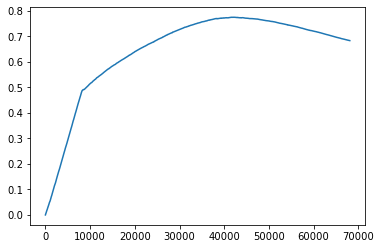

In [128]:
_=build_from_pairs(pairs, valid_df.target.to_list())

In [97]:
def csr_matrix_to_tensor(csr):
    coo = csr.tocoo()
    t = torch.sparse_coo_tensor([coo.row, coo.col], coo.data, csr.shape).cuda()
    return t

def do_chunk_text(embs):
    step = 5000
    for chunk_start in range(0, embs.shape[0], step):
        chunk_end = min(chunk_start+step, embs.shape[0])
        chunk = embs[chunk_start:chunk_end]
        chunk = csr_matrix_to_tensor(chunk).to_dense()
        yield chunk

def generate_text_pairs(data):
    sk_model = sklearn.feature_extraction.text.TfidfVectorizer(stop_words='english', binary=True, max_features=25_000)
    text_embeddings =sk_model.fit_transform(data.title)
    sparse_embs = csr_matrix_to_tensor(text_embeddings)
    dists, inds = get_nearest(sparse_embs, do_chunk_text(text_embeddings))
    pairs = sorted_pairs(dists, inds)[:int(len(data)*10)]
    return pairs

In [98]:
def weave(A,B):
    R = list()
    used = set()
    for a,b in zip(A,B):
        if a[:2] not in used:
            R.append(a)
            used.add(a[:2])
        if b[:2] not in used:
            R.append(b)
            used.add(b[:2])
    return R

In [99]:
pairs_full = generate_text_pairs(valid_df)

0.782 at 5.600910663604736 pairs


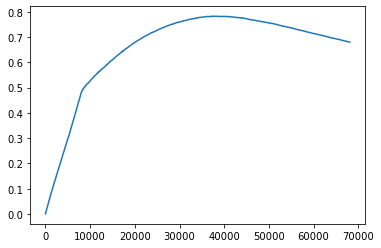

In [100]:
_=build_from_pairs(pairs_full, valid_df.target.to_list())

0.781 at 5.93522310256958 pairs


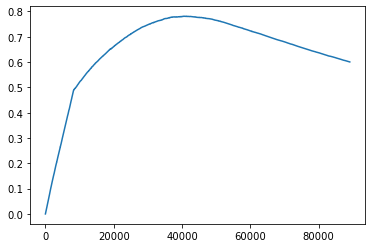

In [101]:
combined = weave(pairs, pairs_full)

_=build_from_pairs(combined, valid_df.target.to_list())

In [102]:
len(pairs)

68080

In [103]:
len(pairs_full)

68080

In [104]:
len(combined) / (len(pairs)+len(pairs_full))

0.6543111045828437

In [105]:
train_embs,_ = embs_from_model(compressor, dls.train)

  0%|          | 0/53 [00:00<?, ?it/s]

In [106]:
train_embs.shape

torch.Size([27136, 512])

In [107]:
dists, inds = get_nearest(train_embs, do_chunk(train_embs))

In [108]:
train_pairs = sorted_pairs(dists, inds)[:len(train_embs)*10]

In [109]:
nonvalid_df=train_df[train_df.is_valid==False].copy().reset_index()
nonvalid_df = add_target_groups(nonvalid_df)

0.442 at 1.1820931434631348 pairs


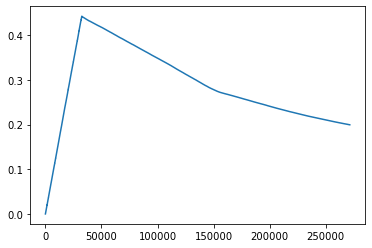

In [111]:
_=build_from_pairs(train_pairs, nonvalid_df.target.to_list())

In [112]:
predsx, predsy = learn.get_preds(ds_idx=0)

In [113]:
predsx.shape, predsy.shape

(torch.Size([27442, 11014]), torch.Size([27442]))

In [114]:
accuracy(predsx, predsy)

TensorBase(0.9911)